### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/folen102/DL_2024_HW_3

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [1]:
from src.data.bpe_tokenizer import BPETokenizer
from src.data.datamodule import DataManager
from src.models.seq2seq_transformer import Seq2SeqTransformer
from src.models.trainer import Trainer
from src.txt_logger import TXTLogger
from tokenizers import Tokenizer
import torch

import warnings
warnings.simplefilter("ignore")

d:\Programs\Anaconda3\envs\ML311\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_manager = DataManager(
    config={
        "prefix_filter": [],
        "filename": 'data/rus.txt',
        "max_length": 15,
        "train_size": 0.8,
        "batch_size": 128
    },
    device=device
)
train_dataloader, val_dataloader = data_manager.prepare_data()

Reading from file: 100%|██████████| 496059/496059 [00:14<00:00, 33718.19it/s]


In [5]:
model = Seq2SeqTransformer(
    device=device,
    embedding_size=256,
    num_encoder_layers=8,
    dim_feedforward=4096,

    src_voc_size=len(data_manager.source_tokenizer.tokenizer.get_vocab()),
    trg_voc_size=len(data_manager.target_tokenizer.tokenizer.get_vocab()),
    source_tokenizer=data_manager.source_tokenizer,
    target_tokenizer=data_manager.target_tokenizer,

    lr_decay_step=5,
    lr=1e-4,
    lr_decay=1e-1
)


In [6]:
trainer_config = {
    'epoch_num': 20
}

logger = TXTLogger(work_dir="./logs")
trainer = Trainer(model, trainer_config, logger)

In [7]:
trainer.train(train_dataloader, val_dataloader)

  5%|▌         | 1/20 [04:59<1:34:47, 299.34s/it]

Current BLEU:  0.029989964982131828
если ты ещё раз так сделаешь я тебя не прощу ---> я не не не ты если это это это
давно мы этого не делали ---> это что это это
что заставило тебя передумать ---> что это ты ты ты ты
ключи от грузовика у меня ---> я я кто
том не спел ту песню которую просила мэри ---> том не не не мэри мэри
##############################


 10%|█         | 2/20 [10:07<1:31:24, 304.67s/it]

Current BLEU:  0.025423708767324343
может показаться что но ю но это не так ---> это может мне я я я
я сказал тому что мы едем на несколько дней в бостон ---> я сказал тому что мы в в бостон в
в этом году у нас похоже будет сне жное рождество ---> нам нам нам это
к сожалению я не могу принять вашего приглашения ---> я я не не не
думаю ты сам только что ответил на свой вопрос ---> думаю думаю ты ты просто
##############################


 15%|█▌        | 3/20 [15:16<1:26:50, 306.51s/it]

Current BLEU:  0.04789941526319977
должна признать что я весьма впечат лена ---> мне надо что что я
фома сел в свою машину завёл мотор и уехал ---> том сел в в и и
ты никого не обма нешь том мы знаем что это ты ---> ты не не не что что что что
больная нога не позволила ему выиграть за бег ---> его не его его его от
это чушь кроме дураков никто в это больше не поверит ---> это никто не не не не
##############################


 20%|██        | 4/20 [20:25<1:21:59, 307.45s/it]

Current BLEU:  0.07158834307295611
в тюрьма х сша находится почти четвер ть всех заключённых мира ---> в в в почти в
после концерта том раз давал автограф ы ---> за на том тома тома
мы играем в пятна шки хочешь с нами ---> мы играть играть ты ты ты с в
том продолжает рассказывать всем какой он богатый ---> том держит все все как он
том очень долго был в австралии ---> том был в в в австралии австралии
##############################


 25%|██▌       | 5/20 [25:34<1:16:59, 307.98s/it]

Current BLEU:  0.05924321156902865
я отложил свою поездку из за плохой погоды ---> я порог свой в из из
эта гостиница принадлежит моему з ят ю ---> эта этом принадлежит мой брат брат
стре коза сколь зила туда сюда над поверх ностью воды почти каса ясь её ---> в была была в в
я думал том ответит на все твои вопросы ---> я думал том всё всё на все вопросы
нет нужды рекла ми ровать хорошее вино ---> не нужно
##############################


 30%|███       | 6/20 [30:45<1:12:05, 308.99s/it]

Current BLEU:  0.06956125391030805
я отнесу ваш чемодан в вашу комнату сэр ---> я буду тебя в в в
не думаю что том знает делать это или нет ---> не думаю что том знает знает это это
я не думаю что том очень хороший лидер ---> не думаю что том очень очень хороший
я надеюсь выбраться из бостона на несколько дней ---> надеюсь надеюсь из из из бостона
мой школьный учитель французского не был носи телем языка ---> мой меня школу французский учитель не не
##############################


 35%|███▌      | 7/20 [35:55<1:07:03, 309.51s/it]

Current BLEU:  0.06542694833078151
оратор должен стоять там где каждый его будет видеть ---> яблоки надо все все его его его его
я бы хотел пройти полное об следо вание ---> я хотел бы чтобы ты тебя в
у меня нет времени играть с тобой в игры ---> у меня нет времени с с с
какого рода подарок ты хотел бы на день рождения ---> какой у ты день день
сколько у тебя знакомых лев шей ---> сколько человек людей ты ты знаешь
##############################


 40%|████      | 8/20 [41:13<1:02:26, 312.22s/it]

Current BLEU:  0.08858128703333024
предпоч те ние одного пола перед другим не доба вит вам здесь друзей ---> на на один по по не не на друзей здесь
том плачет каждый раз как слышит эту песню ---> том каждый раз раз раз песню эту песню песню
зима в этом году мягкая правда это очень приятно ---> этот год что очень очень очень
по крайней мере у меня никогда больше не будет этой проблемы ---> по по бы я никогда никогда не не
я пригласил на обед несколько друзей надеюсь ты не возражаешь ---> я пригласил на друзей я я что не
##############################


 45%|████▌     | 9/20 [46:31<57:34, 314.01s/it]  

Current BLEU:  0.10074164305922495
сбор ка мебели заня ла два часа ---> на ест на два два часа часа
откуда я мог знать что это произойдёт ---> откуда я мог что это это случится
мне больше нечего сказать по теме ---> мне больше нечего сказать сказать
у меня нет других хобби поми мо футбо ла ---> у меня нет нет не не
он занят подготовкой к экзамену ---> он занят занят к
##############################


 50%|█████     | 10/20 [51:48<52:30, 315.01s/it]

Current BLEU:  0.07436278194551846
интересно сможет ли том это сделать ---> интересно сможет ли сможет это сделать
чем кормить ново ро жден ных рыбок кил ли ---> что тебе должен но если если от
я уже начал об этом забывать ---> я уже начал об этом этом
мне бы хотелось посвятить эту песню моей маме ---> я хотел бы дать эту эту
обычно я принимаю душ перед завтраком ---> обычно обычно принял душ перед
##############################


 55%|█████▌    | 11/20 [57:06<47:22, 315.78s/it]

Current BLEU:  0.10955315436793209
в комнате не было никакой мебели ---> в комнате комнате было
мне нужно чтобы том сделал для меня несколько вещей ---> мне нужно чтобы том сделал мне то меня меня меня
том прекратил сту чать в дверь когда понял что мэри нет дома ---> том перестал в в как как как был не дома
прости что том не смог прийти ---> прости том не не прийти
я ищу твою сестру где она ---> я ищу твоя где где она
##############################


 60%|██████    | 12/20 [1:02:28<42:21, 317.67s/it]

Current BLEU:  0.10609206021410354
он сравнил поддел ку с оригина лом ---> он действительно кассиром с с
том кажется не в курсе что мэри это сделала ---> том похоже не не не это мэри
я сожалею что прошлое дело мешает принять мне ваше предложение ---> я жалею что том от от от от от меня от
ты не должен себя за это винить ---> тебе необязательно это это это
после двадцатого октября цены вырастут ---> цены будет будет после октября октября
##############################


 65%|██████▌   | 13/20 [1:07:47<37:06, 318.01s/it]

Current BLEU:  0.10762289398822951
не понимаю что вы пытаетесь сказать ---> я не понимаю что ты пытаешься
я всегда встаю в шесть утра ---> я всегда встаю в часов часов
нельзя быть слишком аккура тным во время езды ---> ты нельзя можешь слишком слишком слишком
вы могли бы и не писать этой последней ф разы в письме ---> ты мог бы в в в в в
том явно недолюбли вает мэри ---> очевидно тому не не нравится тому
##############################


 70%|███████   | 14/20 [1:13:05<31:47, 317.92s/it]

Current BLEU:  0.11840473254557149
я подумал что цена высоко вата ---> я думал это цена цена
дети играют в прятки ---> дети играют в и
что у вас завтра за собрание ---> какие у тебя завтра завтра
во многих странах мень шин ства презира ются ---> в в много в в в
том уронил на пол вилку принесите ему чистую пожалуйста ---> том уронил свою на на
##############################


 75%|███████▌  | 15/20 [1:18:24<26:31, 318.27s/it]

Current BLEU:  0.15343210322410872
том определенно выглядит моложе мэри ---> том определённо выглядит моложе мэри
нам нужна группа людей на которых мы можем положиться ---> нам нужно цеп людей мы мы мы можем
том ушёл никому ничего не сказав ---> том оставил никому не никому кем кем
том и мэри начали говорить одновременно ---> том и мэри начали говорить
мы с томом через многое прошли вместе ---> мы с томом очень вместе вместе вместе
##############################


 80%|████████  | 16/20 [1:23:57<21:31, 322.81s/it]

Current BLEU:  0.11030119115949309
том насвисты вал мелодию на своем пути вдоль реки ---> том дядя с с с с реку
трудно оце нить человече скую жизнь ---> трудно трудно для по слёз
с чего ты решил что я что то скрываю ---> с чего ты взял что что что то то то
они все ждали что я что нибудь скажу ---> они все ждали что что я то то
я не знаю где том купил этот компьютер ---> я не знаю где том купил компьютер компьютер
##############################


 85%|████████▌ | 17/20 [1:29:26<16:13, 324.57s/it]

Current BLEU:  0.11654383599342502
том сказал что мэри не очень хорошо себя чувствует ---> том сказал что мэри не очень хорошо чувствует чувствует
если бы он сказал мне правду я бы его простил ---> если он сказал мне мне правду я бы
первым чер ноко жим президентом сша был бара к оба ма ---> первый первый сознается из из секу в
ты можешь разобрать что он пытается сказать ---> ты можешь что что пытается пытается
пока мы любим друг друга всё будет в порядке ---> сколько мы как мы мы
##############################


 90%|█████████ | 18/20 [1:34:45<10:45, 322.88s/it]

Current BLEU:  0.12680393056939662
кого нибудь из вашей семьи когда нибудь арестовывали ---> в нибудь кто в нибудь нибудь нибудь арестовали
крыло бабочки содержит множество деталей ---> в это много много много много
у тома не было времени закончить отчёт ---> у тома не времени времени отчёт
том открыл окно и впустил немного свежего воздуха ---> том открыл окно и немного геолог
том почти ничего не видит без очков ---> том почти ничего ничего ничего ничего без
##############################


 95%|█████████▌| 19/20 [1:40:08<05:23, 323.14s/it]

Current BLEU:  0.12338125725428156
лицо тома выра жало отчая ние ---> у тома было лице лице лице
интересно что бы сказал том если бы это случилось ---> интересно что бы том бы бы бы
не покупай машину у этого ди ле ра тебя наду ют ---> не покупай машину машину от от с
не думаю что нам стоит это покупать ---> я не думал что нам это покупать
мой отец говорит как по английски так и по французски ---> мой отец говорит по французски французски по как
##############################


100%|██████████| 20/20 [1:45:30<00:00, 316.53s/it]

Current BLEU:  0.1078404233246319
его дом был продан за десять тысяч долларов ---> его дом был продал за десять десять долларов
я надеюсь что увижу его в понедельник ---> я жду что увижу в ним понедельник понедельник
какой фрукт в японии самый вкусный ---> какой самый смей всего в в
какой из этих автобусов идёт в центр ---> какой из этих этих затекла в
в прошлом году он провел три месяца в море ---> в прошлом году год три три три в
##############################
Last 19 epoch train loss:  0.9934004148737116
Last 19 epoch val loss:  3.2439692728072997
Last 19 epoch val bleu:  0.1078404233246319


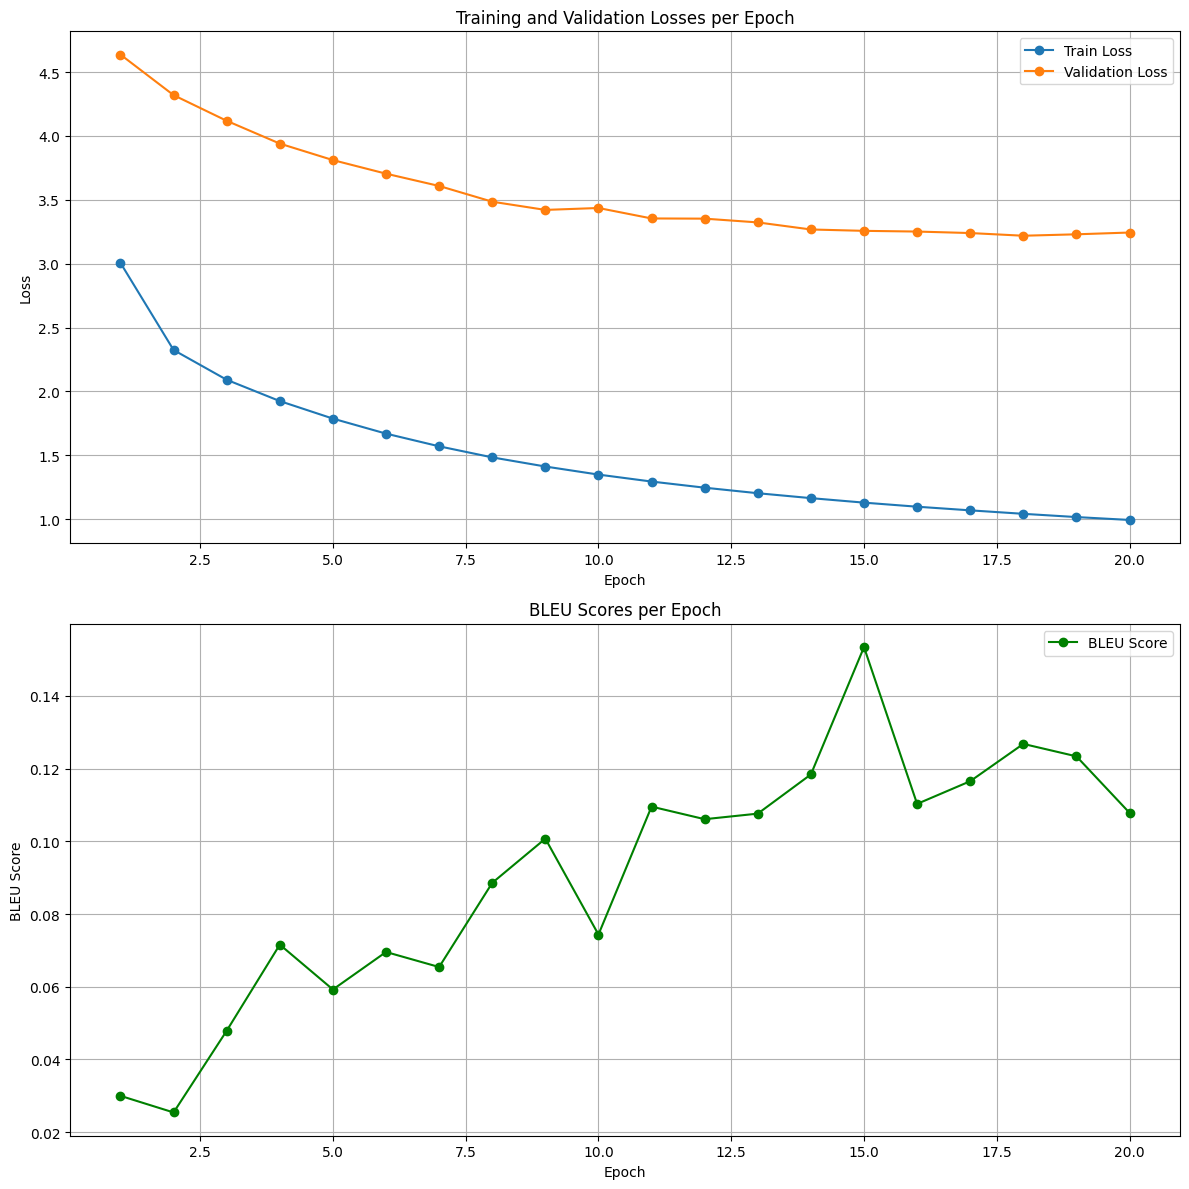

In [8]:

import matplotlib.pyplot as plt

file_path = 'logs/progress_log.txt'

epoch_nums = []
val_losses = []
train_losses = []
bleu_scores = []

with open(file_path, 'r') as file:
    for line in file:
        if 'epoch_num' not in line:
            data = eval(line.strip())
            val_losses.append(data['val_loss'])
            train_losses.append(data['train_loss'])
            bleu_scores.append(data['bleu_score'])
            epoch_nums.append(len(epoch_nums) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(epoch_nums, train_losses, label='Train Loss', marker='o')
ax1.plot(epoch_nums, val_losses, label='Validation Loss', marker='o')
ax1.set_title('Training and Validation Losses per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epoch_nums, bleu_scores, label='BLEU Score', color='green', marker='o')
ax2.set_title('BLEU Scores per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('BLEU Score')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [9]:
sentences_to_translate = [
    "you work hard",
    "tom was sick",
    "summer is here",
    "tom will win",
    "i wonder where she lives",
    "you will be there again soon",
    "i rarely make a mistake",
    "i knew all about that",
    "i plan on going there",
    "we are going to swim"
]

def translate_sentences(model, sentences):
    model.eval()
    predicted_sentences = model.predict(sentences)
    return [" ".join(sentence) for sentence in predicted_sentences]

translated_sentences = translate_sentences(model, sentences_to_translate)
for translated in translated_sentences:
    print(translated)


ты много работаешь
том был болен
лето лето
том выиграет
интересно где она живёт
ты скоро скоро там
я редко делаю ошибку
я всё об этом знал
я планирую туда пойти
мы будем плавать


### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [6]:
# CODE HERE